In [1]:
!curl -X GET "localhost:9200/"

{
  "name" : "8202d20318fa",
  "cluster_name" : "docker-cluster",
  "cluster_uuid" : "9Uw7ztzPTnyT-3HMKW1SbQ",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "docker",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


# Initializing Document Store
- First, iterate through all unique documents and write them to the database
- Finally, test whether the document store is able to retrieve the stored document

In [2]:
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [3]:
from datasets import load_dataset
dataset = load_dataset("csv", data_files=["electronics/splits/train.csv", "electronics/splits/test.csv", \
                                         "electronics/splits/dev.csv"])["train"]
dataset = dataset.train_test_split(test_size=0.1)

Found cached dataset csv (/home/matoanderson/.cache/huggingface/datasets/csv/default-92c4c30cf6fed825/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
dfs = {split: dset.to_pandas() for split, dset in dataset.flatten().items()} #store each split as separate DF

In [5]:
for split, df in dfs.items():
    docs=[{"content": row["review"], "id": row["review_id"], "meta":{"item_id": row["item_id"], \
        "question_id": row["q_review_id"], "split": split}} \
         for _, row in df.drop_duplicates(subset="review_id").iterrows()]
    document_store.write_documents(documents=docs, index="document")

In [6]:
from haystack.nodes.retriever import BM25Retriever
bm25_retriever = BM25Retriever(document_store=document_store)

In [7]:
query = dataset["test"][4]["question"]
retrieved_docs = bm25_retriever.retrieve(query=query, top_k=3, filters={"split":["test"]})
print(retrieved_docs[0])
print(f"Actual id is: {dataset['train'][0]['review_id']}")

<Document: id=68b06e03335cc5c3b93602b2f53b7b37, content='I've been a fan of Samsung for years and this is the first time I've strayed from my usual brand. Wh...'>
Actual id is: 623cec49e7b276eb75f7f5ca5b1c6bdf


# Simple Pipeline
- First, initialize the reader and the pipeline
- Next, make a simple prediction

In [8]:
from haystack.nodes import FARMReader
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False, \
                   max_seq_len=max_seq_length, doc_stride=doc_stride, return_no_answer=True)

/home/matoanderson/.local/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [9]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)

In [10]:
n_answers = 3
preds = pipe.run(query=query, params={"Retriever": {"top_k": 3, "filters":{"split":["train"]}}, \
                                      "Reader":{"top_k": n_answers}})

In [11]:
print(f"Question: {preds['query']}\n")
for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippter: ...{preds['answers'][idx].context}...")
    print("\n")

Question: How would you describe the build of the camera?

Answer 1: perfectly fine
Review snippter: ... know.Some people complain about the build quality.  Trust me, it's perfectly fine.  It's light, which can be misleading.  But there's nothing wrong w...


Answer 2: 
Review snippter: ...None...


Answer 3: perfectly comfortable
Review snippter: ...y expect more for $400.  I guess I can understand that.  But I'm perfectly comfortable with the build quality.The competition for this camera are the ...




# Baseline Evaluation

- Create a list of label objects for the document store for later evaluation
- Initiate a pipeline for the retriever only (since both components should be evaluated separately)
- Initiate another pipeline to evaluate the reader

In [12]:
from haystack import Label, Answer, Document
labels = []
for i, row in dfs["test"].iterrows(): 
    meta = {"item_id":  row["item_id"], "question_id": row["q_review_id"]}
    if row["human_ans_spans"] != "ANSWERNOTFOUND": #not an empty answer
        label = Label(query=row["question"], answer=Answer(answer=row["human_ans_spans"]), origin="gold-label", \
                  document=Document(content=row["review"], id=row["review_id"]),
                  is_correct_answer=True, is_correct_document=True, no_answer=False, \
                  filters={"item_id": [meta["item_id"]], "split":["test"]})
        labels.append(label)
    else:
        label = Label(query=row["question"], answer=Answer(answer=""), origin="gold-label", \
                     document=Document(content=row["review"], id=row["review_id"]), meta=meta, \
                     is_correct_answer=True, is_correct_document=True, no_answer=True, \
                     filters={"item_id": [row["item_id"]], split:"test"})
        labels.append(label)
document_store.write_labels(labels, index="label") 
labels = document_store.get_all_labels_aggregated(index="label", open_domain=True, aggregate_by_meta=["item_id"])

In [13]:
from haystack.pipelines import DocumentSearchPipeline
pipe = DocumentSearchPipeline(retriever=bm25_retriever)

In [14]:
eval_result = pipe.eval(labels=labels, params={"Retriever": {"top_k": 3}})
metrics = eval_result.calculate_metrics()
print(f"Recall for Retriver: {metrics['Retriever']['recall_single_hit']:.2f}") 

Recall for Retriver: 0.69


In [15]:
from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ["exact_match", "f1"]
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])
    eval_result = p.eval(labels=labels, documents=[[label.document for label in multilabel.labels] \
                                                  for multilabel in labels], params={})
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}
reader_eval = {}
reader_eval["fine-tuned on SQuAD"] = evaluate_reader(reader)

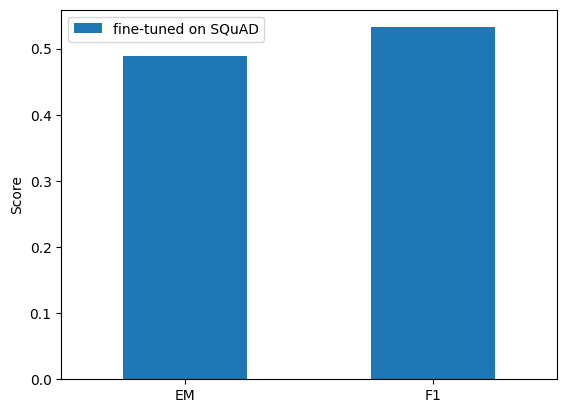

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval)
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc="upper left")
    plt.show()
plot_reader_eval(reader_eval)
    

# Dense Passage Retrieval
- Using two BERT models as encoders for the question and passage. The dot product similarity between the two vectors will result in the new document score
- Update the embeddings and run the evaluation again

In [17]:
from haystack.nodes import DensePassageRetriever
dpr_retriever = DensePassageRetriever(document_store=document_store, \
                                     query_embedding_model="facebook/dpr-question_encoder-single-nq-base", \
                                     passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base", \
                                     embed_title=False)

/home/matoanderson/.local/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.


In [18]:
document_store.update_embeddings(retriever=dpr_retriever)
pipe = DocumentSearchPipeline(retriever=dpr_retriever)
eval_result = pipe.eval(labels=labels, params={"Retriever": {"top_k":3}})
metrics = eval_result.calculate_metrics()
print(f"Recall for Retriever: {metrics['Retriever']['recall_single_hit']:.2f}")

Updating embeddings:   0%|          | 0/1615 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/1616 [00:00<?, ? Docs/s]

Recall for Retriever: 0.69


- Did not improve the retriever, but still the default choice for embeddings 

# Fine-Tuning the Reader
- Training the reader requires an additional, yet important, step: converting the data into SQuAD JSON format

In [19]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["review"]))
    for document_id, document in id2context.items():
        qas = []
        document_df = df.query(f"review_id == '{document_id}'")
        id2question = dict(zip(document_df["q_review_id"], document_df["question"]))
        for qid, question in id2question.items():
            question_df = document_df.query(f"q_review_id == '{qid}'").to_dict(orient="list")
            ans_start_idx = [i.find(",") for i in question_df["human_ans_indices"]] #"(start, end)"
            ans_start = [int(j[1:ans_start_idx[i]]) for i,j in enumerate(question_df["human_ans_indices"])]
            ans_text = question_df["human_ans_spans"]
            
            answers = [{"text": text, "answer_start": start} for text, start in zip(ans_text, ans_start) \
                          if text != "ANSWERNOTFOUND"]
            is_impossible = False
            if not answers: #no valid answers
                is_impossible = True
            qas.append({"question": question, "id": qid, "is_impossible": is_impossible, "answers": answers})
        paragraphs.append({"qas": qas, "context": document})
    return paragraphs

In [20]:
import json
def convert_to_squad(dfs):
    for split, df in dfs.items():
        qa_data = {}
        paragraphs = df.groupby("item_id").apply(create_paragraphs).to_frame(name="paragraphs").reset_index()
        qa_data["data"] = paragraphs.to_dict(orient="records")
        with open(f"qa-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(qa_data, f)
convert_to_squad(dfs)

In [21]:
train = "qa-train.json"
dev = "qa-test.json"
reader.train(data_dir=".", use_gpu=True, n_epochs=5, batch_size=4, train_filename=train, dev_filename=dev)

Preprocessing dataset:   0%|          | 0/4 [00:00<?, ? Dicts/s]

Answer 'Bass is weak as expected , even with EQ adjusted up' not contained in context.
Example will not be converted for training/evaluation.
Answer 'These headphones are n't very' not contained in context.
Example will not be converted for training/evaluation.
Answer 'The picture quality is solid sharp and amazing' not contained in context.
Example will not be converted for training/evaluation.
Answer 'is is the 1.4' not contained in context.
Example will not be converted for training/evaluation.
Answer 'tripod to let you see how well it works . The tripod does look quite cheap in construction' not contained in context.
Example will not be converted for training/evaluation.
Answer 'I can fit about 5 lenses and a camera body in this case .' not contained in context.
Example will not be converted for training/evaluation.
Answer 'the resulting images will be very soft .   It sharpens up nicely by f/4' not contained in context.
Example will not be converted for training/evaluation.
Answer

Answer 'I was lucky to get this lens for $ 199 from Amazon' not contained in context.
Example will not be converted for training/evaluation.
Answer 'The LCD screen on the back is crisp , clear , and bright so you can see it even in daylight' not contained in context.
Example will not be converted for training/evaluation.
Answer 'Ok folks , I normally do n't write reviews but' not contained in context.
Example will not be converted for training/evaluation.
Answer 'the bass easily audible' not contained in context.
Example will not be converted for training/evaluation.
Answer 'than you 're used to compared to Nikon or Zeiss lenses' not contained in context.
Example will not be converted for training/evaluation.
Answer 'full volume' not contained in context.
Example will not be converted for training/evaluation.
Answer 'this is a very affordable and effective computer audio solution .' not contained in context.
Example will not be converted for training/evaluation.
Answer 'These speakers 

Answer 'I would n't buy a different one' not contained in context.
Example will not be converted for training/evaluation.
Answer 'The Trackman Wheel , unfortunately , had a few issues . I did n't mind that it was wired . I did , however , find myself frustrated with the lack of forward and back buttons .' not contained in context.
Example will not be converted for training/evaluation.
Answer 'The trackball now has additional " back / forward " buttons although they are located in an odd location that requires you to use your index fingers' not contained in context.
Example will not be converted for training/evaluation.
Answer 'The router took about 10 ' to install and has worked like a charm since then' not contained in context.
Example will not be converted for training/evaluation.
Answer 'There is no software to install the CD just contains instructions and will tell you if your connection is good' not contained in context.
Example will not be converted for training/evaluation.
Answe

Answer 'Fast , easy setup' not contained in context.
Example will not be converted for training/evaluation.
Answer 'I could n't be happier with this tablet' not contained in context.
Example will not be converted for training/evaluation.
Answer 'of of of of of of' not contained in context.
Example will not be converted for training/evaluation.
Answer 'The lens tack sharp' not contained in context.
Example will not be converted for training/evaluation.
Answer 'There are definitely some damaged cards out there so be wary and do not hesitate to call customer service' not contained in context.
Example will not be converted for training/evaluation.
Answer 'case actually like it' not contained in context.
Example will not be converted for training/evaluation.
Answer 'The drive does nt get very warm even when transferring files' not contained in context.
Example will not be converted for training/evaluation.
Answer 'our phones could n't get a wifi signal' not contained in context.
Example wil

Preprocessing dataset:   0%|          | 0/1 [00:00<?, ? Dicts/s]

Answer 'crystal clear and BIG Bass booms' not contained in context.
Example will not be converted for training/evaluation.
Answer 'Do n't let brand name Cable makers convince you that their cables are really that different than this one' not contained in context.
Example will not be converted for training/evaluation.
Answer 'The auto focus is nice' not contained in context.
Example will not be converted for training/evaluation.
Answer 'Now it has become the most comfortable keyboard I 've ever used' not contained in context.
Example will not be converted for training/evaluation.
Answer 'It 's totally plug play and it detects when a device connected' not contained in context.
Example will not be converted for training/evaluation.
Answer 'The speakers are still great eventually' not contained in context.
Example will not be converted for training/evaluation.
Answer 'Sigma has a real winner here .' not contained in context.
Example will not be converted for training/evaluation.
Answer 'am

Evaluating:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/142 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/142 [00:00<?, ?it/s]

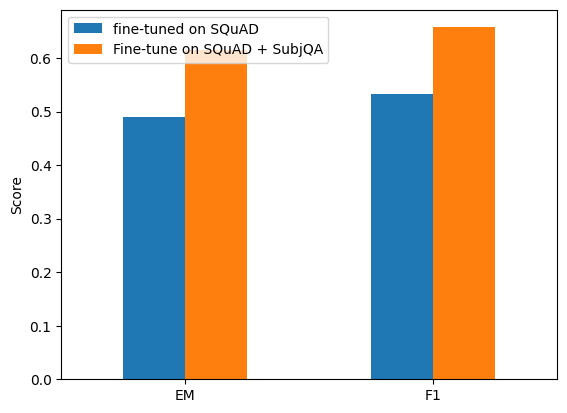

In [22]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)
plot_reader_eval(reader_eval)

- Training definitely increases both scores

# Inference
- The same query as before. This time with much more accurate replies

In [23]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)
n_answers = 3
preds = pipe.run(query=query, params={"Retriever": {"top_k": 3, "filters":{"split":["train"]}}, \
                                      "Reader":{"top_k": n_answers}})
print(f"Question: {preds['query']}\n")
for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippter: ...{preds['answers'][idx].context}...")
    print("\n")

Question: How would you describe the build of the camera?

Answer 1: Some people complain about the build quality
Review snippter: ...of that in processing JPEGs, so most will never know.Some people complain about the build quality.  Trust me, it's perfectly fine.  It's light, which ...


Answer 2: this camera is built for the serious enthusiast
Review snippter: ...hort of a DSLR camera, it has no equal.In addition, this camera is built for the serious enthusiast.  Full manual controls make it almost like having ...


Answer 3: poor durability
Review snippter: ... Playsport died halfway through my honeymoon. I am astounded by the poor durability of this unit and am glad I brought my Canon camera w/ UW case as a...


